# # Analysing US hospital costs using chargemaster data

As of 2019, all US hospitals are required to release a charge sheet (known as a chargemaster) for each service that they provide. For those with insurance, these costs are not necessarily the final out of pocket amount, however these numbers can be studied to explore costs within the US hospital system. 

For an exploratory data analysis, 6 hospitals were chosen:
Arizona Hospital
The Cleveland Clinic
John Hopkins
Mount Sinai
NY Presyterian
UCSFMC

The aims of the exploratory analysis will be twofold. The first objective is to examine the relative price differences between hospitals, for similar procedures. This will be tested by examining the 300 most expensive procedures at each hospital (with more in the final analysis, however the current implementation scales O(N^2), where N is the number of procedures collected from all hospitals), and then using fuzzy string matching to match procedure names from each hospital, before discarding low-match strings. 

The second goal will be to explore the relative distribution of chemotherapy related procedures, across all hospitals. 

The overall aim of the project would be to understand the relative demographic and geographic factors that drive a "fair" price for a procedure at a hospital, and then consider hospitals charging behaviour relative to such a cost, with the aim to empower consumers, foster innovation and competition, and overall . 

First step is to establish the necessary tools, and then import and store all the relevant data in two pandas dataframes. 

In [19]:
import pandas as pd # Pandas will be used for storing and operating on the data
import numpy as np # Numpy will be used for additional mathematical operations
import os
import string
from fuzzywuzzy import fuzz
from fuzzywuzzy import process as proc
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pylab as plt
import seaborn as sns

#pd.set_option('display.max_columns', 500)

def std(x): return np.std(x)
def mean(x): return np.mean()

directory = os.fsencode("C:\DataIncubator\Medical")
directory_path = "C:\\DataIncubator\\Medical\\"

df_aggregate = pd.DataFrame()
df_keyword_aggregate = pd.DataFrame()

def line_preprocessor(line):
    line = line.lower()
    return line

def process(df, filename):
    df['Location'] = filename.split('.')[0]
    df = df.drop(columns=['Dummy'])
    df = df.nlargest(300,'Cost') # Discard all bar the first 300 entries
    return df

def process_keyword(df, filename,keyword):
    df['Location'] = filename.split('.')[0]
    df = df.drop(columns=['Dummy'])
    df = df[df['Procedure'].str.contains(keyword)] # Discard all entries that do not contain the keyword, which will be chemo
    return df

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".xlsx"):
        print(filename)
        path = directory_path + filename
        df = pd.read_excel(path, names=['Dummy','Procedure','Cost'])
        df_aggregate = pd.concat([df_aggregate, process(df,filename)])
        df_keyword_aggregate = pd.concat([df_keyword_aggregate, process_keyword(df,filename,'CHEMO')])
    if filename.endswith(".xls"):
        print(filename)
        path = directory_path + filename
        df = pd.read_excel(path, names=['Dummy','Procedure','Cost'])
        df_aggregate = pd.concat([df_aggregate, process(df,filename)])
        df_keyword_aggregate = pd.concat([df_keyword_aggregate, process_keyword(df,filename,'CHEMO')])
    if filename.endswith(".csv"):
        print(filename)
        path = directory_path + filename
        df = pd.read_csv(path, names=['Dummy','Procedure','Cost'])
        df_aggregate = pd.concat([df_aggregate, process(df,filename)])
        df_keyword_aggregate = pd.concat([df_keyword_aggregate, process_keyword(df,filename,'CHEMO')])
    

df_aggregate['Procedure'] = df_aggregate['Procedure'].str.replace(r'[^\w\s]+', ' ')

df = df_aggregate
df_keyword = df_keyword_aggregate

Arizona_hospital.xlsx
Cleveland_Clinic.xlsx
John_Hopkins.xlsx
Mount_Sinai.xlsx
NY_Presbyterian.xlsx
UCSFMC.xlsx


Next we search through each procedure at each location, and find the closest match with all strings at all other locations. From here the cost, cost difference, and normalised price difference (nominally the percentage difference, as calculated by [a - b]/((1/2)*(a + b)), where a and b are the costs at the two matching locations.

In [20]:
df['Match'] = -1
df['Match Score'] = 0
df['Complimentary Cost'] = 0
df['Price Delta'] = 0
df['Normalised Delta'] = 0

#df.reindex()

print(df.shape)
df = df[~df.index.duplicated(keep='first')]
df_keyword = df_keyword[~df_keyword.index.duplicated(keep='first')]
print(df.shape)

# Iterating through each row, finding the best match within the remainder of the data set (excluding the same hospital)
# Would be faster if functionalised
for index, row in df.iterrows():
    choices = df[df['Location'] != row['Location']]['Procedure'].unique()
    matching_result = proc.extract(row['Procedure'], choices, limit=1, scorer=fuzz.token_sort_ratio)

    match_score = matching_result[0][1]
    match_location = df.index[(df['Location'] != row['Location']) & (df['Procedure'] == matching_result[0][0])][0]
    if match_score > row['Match Score']:
        df.loc[index, 'Match'] = match_location
        df.loc[index, 'Match Score'] = match_score
        df.loc[index, 'Complimentary Cost'] = df.loc[match_location]['Cost']
        df.loc[index,'Price Delta'] = row['Cost'] - df.loc[match_location]['Cost']
        df.loc[index, 'Normalised Delta'] = 2*(row['Cost'] - df.loc[match_location]['Cost'])/((row['Cost'] + df.loc[match_location]['Cost']))
        
    if match_score > df.loc[match_location, 'Match Score']:
        df.loc[match_location, 'Match'] = index
        df.loc[match_location, 'Match Score'] = match_score
        df.loc[match_location, 'Complimentary Cost'] = row['Cost']
        df.loc[match_location,'Price Delta'] = -row['Cost'] + df.loc[match_location]['Cost']
        df.loc[match_location, 'Normalised Delta'] = 2*(-row['Cost'] + df.loc[match_location]['Cost'])/((row['Cost'] + df.loc[match_location]['Cost']))
            

def processing_function(df, location, location2):
    indices = df.index[(df['Location'] == location)]
    indices_matching = df.index[(df['Location'] == location2)]

    
    for index, row in df[df['Location'] == location].iterrows():
        choices = df.loc[indices_matching, :]['Procedure'].unique()
        matching_result = proc.extract(row['Procedure'], choices, limit=1, scorer=fuzz.token_sort_ratio)
        match_score = matching_result[0][1]
        match_location = df.index[(df['Location'] != row['Location']) & (df['Procedure'] == matching_result[0][0])][0]

        #if match_score > row['Match Score']:
        if True:
            df.loc[index, location2 + 'Match'] = match_location
            df.loc[index, location2 + 'Match Score'] = match_score
            df.loc[index, location2 + 'Complimentary Cost'] = df.loc[match_location]['Cost']
            df.loc[index, location2 + 'Price Delta'] = row['Cost'] - df.loc[match_location]['Cost']
            df.loc[index, location2 + 'Normalised Delta'] = (row['Cost'] - df.loc[match_location]['Cost'])/(2*(row['Cost'] + df.loc[match_location]['Cost']))
            
        #if match_score > df.loc[match_location, 'Match Score']:
        if True:
            df.loc[match_location, location + 'Match'] = index
            df.loc[match_location, location + 'Match Score'] = match_score
            df.loc[match_location, location + 'Complimentary Cost'] = row['Cost']
            df.loc[match_location, location + 'Price Delta'] = -row['Cost'] + df.loc[match_location]['Cost']
            df.loc[match_location, location + 'Normalised Delta'] = (-row['Cost'] + df.loc[match_location]['Cost'])/(2*(row['Cost'] + df.loc[match_location]['Cost']))

(1800, 8)
(1773, 8)


Now the mean and std distribution of the relative costs is calcualted. Of particular interest is how each hospital compares to all other hospitals for overcharging, and this data will be presented as a heatmap

c:\users\cullena\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


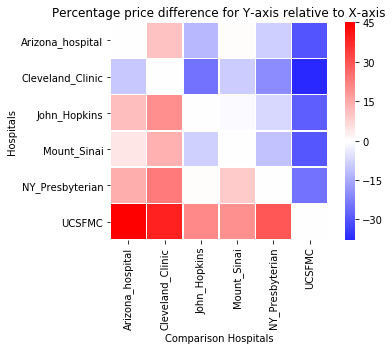

In [21]:
results_frame = []
results_std_frame = []
labels = []
        
for location in df['Location'].unique():
    labels.append(location)
    for location2 in df['Location'].unique():
        if location == location2:
            # Result = 0
            Result = 0
        else:
            processing_function(df, location, location2)

    for location2 in df['Location'].unique():
        results_frame.append(df[(df['Match Score'] > 85) & (df['Location'] == location)][location2 + 'Normalised Delta'].mean())
        results_std_frame.append(df[(df['Match Score'] > 85) & (df['Location'] == location)][location2 + 'Normalised Delta'].std())

#print(results_frame)
#print(results_std_frame)
results_frame = [i if np.isnan(i)==False else 0 for i in results_frame]
num_hospitals = int(np.sqrt(len(results_frame)))
results_frame = np.asarray(results_frame).reshape(num_hospitals, num_hospitals)
results_std_frame = [i if np.isnan(i)==False else 0 for i in results_std_frame]
results_std_frame = np.asarray(results_std_frame).reshape(num_hospitals, num_hospitals)



#print(df[df['Match Score'] > 85].sort_values(['Price Delta']).head())
#print(df[df['Match Score'] > 85][['Procedure','Location','Match Score','Cost','Complimentary Cost','Normalised Delta']].sort_values(['Normalised Delta']).head())
#print(df.mean())
#print(df[df['Match Score'] > 85].mean())

ax = sns.heatmap(results_frame*100, linewidth=.5, square=True, center=0, cmap="bwr", xticklabels=labels, yticklabels=labels)
ax.set(xlabel='Comparison Hospitals', ylabel='Hospitals', title='Percentage price difference for Y-axis relative to X-axis')
plt.show()

This graph can be read by examining the horizontal rows. A red colouration in a row corresponds to overcharging, relative to the hospital presented in the column. Similarly, a blue colouration in a row corresponds to undercharging, relative to the hospital presented in the column. 

Cancer can be a significant driver of individual healthcare costs, due to the need to potentially undergo multiple rounds of chemotherapy and radiotherapy. To compare how the associated costs with chemotherapycan affect a patient at different hospitals, a Kernel density estimate (KDE) is conducted on the costs of all Chemotherapy related therapies provided by each hospital. The KDE was chosen, as it allows the underlying probability distribution to be estimated based upon a relatively sparse histogram dataset. 

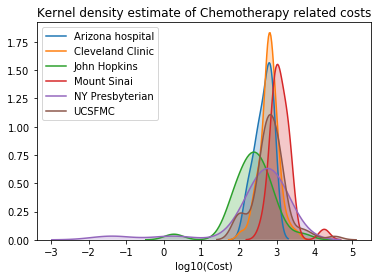

In [22]:
for location in df_keyword['Location'].unique():
    ax = sns.kdeplot(np.log10(df_keyword[df_keyword['Location'] == location]['Cost']), shade=True, label=location.replace('_',' '))
    

ax.set(xlabel="log10(Cost)", title="Kernel density estimate of Chemotherapy related costs")
plt.show()

Arizona Hospital and the Cleveland Clinic share near identical price distributions, and are both uniformly offset by a factor of ~3 from Mount Sinai Hospital. This difference may be a product of geographic differences (with Mount Sinai being located in New York) or differences in the relative reputations of each clinic to allow for Mount Sinai to offer similar services at an increased cost. 

The driving factor may well be reputational, rather than geographic, as NY Presbyterian offers the majority of its chemotherapy related services at a lower cost than Mount Sinai, and with a distribution that skews towards the low end. Further analysis would be required to probe these differences, as NY Presbyterian has a long tail on the low side that is unique amongst service providers, which could indicate that while their top end prices are lower, they may be billing more services for a given patient. 

In the context of the relative price differences in the first figure, it is clear that relative pricing rates are not uniform across all procedures, as UCSFMC has the highest overall billing rate of all the studied hospitals, but this is not the case for Chemotherapy related treatments. 

Based upon the initial analysis contained within this notebook, it is clear that there are significant pricing disparities across US hospitals that would be well suited for a broader meta-analysis into the factors (geographic, reputatoinal, location, demographics, service quality and standards) that drive these costs, both on a broad level, and for specific treatment categories. 

Arizona_hospital.xlsx
Brigham and Womens.xlsx
Cleveland_Clinic.xlsx
Cooper University.csv
Duke Raleigh.xlsx
Duke Regional.xlsx
Duke University Hospital.xlsx
Henry Ford Hospital.xlsx
Jackson Health.xlsx
John_Hopkins.xlsx
Mass General.xlsx
Mclean Hospital.xlsx
Methodist Hospital.xlsx
Mount_Sinai.xlsx
NY_Presbyterian.xlsx
Ochsner Baptist.csv
UC Irvine.xlsx
UCSFMC.xlsx
YNHH.xlsx
(421, 8)
(390, 8)
Arizona_hospital
Cleveland_Clinic
Cooper University
Duke Raleigh
Duke Regional
Duke University Hospital
Henry Ford Hospital
Jackson Health
John_Hopkins
Methodist Hospital
NY_Presbyterian
UC Irvine
UCSFMC
YNHH


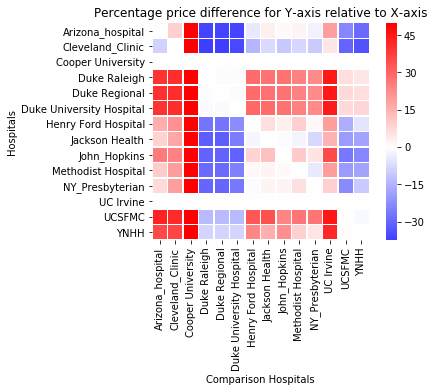

In [32]:
df_save = df
df_keyword_save = df_keyword

directory = os.fsencode("C:\DataIncubator\MedicalLarge")
directory_path = "C:\\DataIncubator\\MedicalLarge\\"

df_aggregate = pd.DataFrame()
df_keyword_aggregate = pd.DataFrame()

def process_small(df, filename):
    df['Location'] = filename.split('.')[0]
    df = df.drop(columns=['Dummy'])
    df.head()
    
    df = df[df.applymap(np.isreal)['Cost']]
    df['Cost'] = pd.to_numeric(df['Cost'])
    df = df.nlargest(30,'Cost') # Discard all bar the first 50 entries
    return df

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".xlsx"):
        print(filename)
        path = directory_path + filename
        df = pd.read_excel(path, names=['Dummy','Procedure','Cost'])
        df_aggregate = pd.concat([df_aggregate, process_small(df,filename)])
        #df_keyword_aggregate = pd.concat([df_keyword_aggregate, process_keyword(df,filename,'CHEMO')])
    if filename.endswith(".xls"):
        print(filename)
        path = directory_path + filename
        df = pd.read_excel(path, names=['Dummy','Procedure','Cost'])
        df_aggregate = pd.concat([df_aggregate, process_small(df,filename)])
        #df_keyword_aggregate = pd.concat([df_keyword_aggregate, process_keyword(df,filename,'CHEMO')])
    if filename.endswith(".csv"):
        print(filename)
        path = directory_path + filename
        df = pd.read_csv(path, names=['Dummy','Procedure','Cost'])
        df_aggregate = pd.concat([df_aggregate, process_small(df,filename)])
        #df_keyword_aggregate = pd.concat([df_keyword_aggregate, process_keyword(df,filename,'CHEMO')])
        
df_aggregate['Procedure'] = df_aggregate['Procedure'].str.replace(r'[^\w\s]+', ' ')

df = df_aggregate
df_keyword = df_keyword_aggregate

df['Match'] = -1
df['Match Score'] = 0
df['Complimentary Cost'] = 0
df['Price Delta'] = 0
df['Normalised Delta'] = 0

#df.reindex()

print(df.shape)
df = df[~df.index.duplicated(keep='first')]
df_keyword = df_keyword[~df_keyword.index.duplicated(keep='first')]
print(df.shape)

# Iterating through each row, finding the best match within the remainder of the data set (excluding the same hospital)
# Would be faster if functionalised
for index, row in df.iterrows():
    choices = df[df['Location'] != row['Location']]['Procedure'].unique()
    matching_result = proc.extract(row['Procedure'], choices, limit=1, scorer=fuzz.token_sort_ratio)

    match_score = matching_result[0][1]
    match_location = df.index[(df['Location'] != row['Location']) & (df['Procedure'] == matching_result[0][0])][0]
    if match_score > row['Match Score']:
        df.loc[index, 'Match'] = match_location
        df.loc[index, 'Match Score'] = match_score
        df.loc[index, 'Complimentary Cost'] = df.loc[match_location]['Cost']
        df.loc[index,'Price Delta'] = row['Cost'] - df.loc[match_location]['Cost']
        df.loc[index, 'Normalised Delta'] = 2*(row['Cost'] - df.loc[match_location]['Cost'])/((row['Cost'] + df.loc[match_location]['Cost']))
        
    if match_score > df.loc[match_location, 'Match Score']:
        df.loc[match_location, 'Match'] = index
        df.loc[match_location, 'Match Score'] = match_score
        df.loc[match_location, 'Complimentary Cost'] = row['Cost']
        df.loc[match_location,'Price Delta'] = -row['Cost'] + df.loc[match_location]['Cost']
        df.loc[match_location, 'Normalised Delta'] = 2*(-row['Cost'] + df.loc[match_location]['Cost'])/((row['Cost'] + df.loc[match_location]['Cost']))
            
results_frame = []
results_std_frame = []
labels = []

def processing_function_faster(df, location, location2):
    indices = df.index[(df['Location'] == location)]
    indices_matching = df.index[(df['Location'] == location2)]

    choices = df.loc[indices_matching, :]['Procedure'].unique()
    
    for index, row in df.loc[indices,:].iterrows():    
        matching_result = proc.extract(row['Procedure'], choices, limit=1, scorer=fuzz.token_sort_ratio)
        match_score = matching_result[0][1]
        match_location = df.index[(df['Location'] != row['Location']) & (df['Procedure'] == matching_result[0][0])][0]

        #if match_score > row['Match Score']:
        if True:
            df.loc[index, location2 + 'Match'] = match_location
            df.loc[index, location2 + 'Match Score'] = match_score
            df.loc[index, location2 + 'Normalised Delta'] = (row['Cost'] - df.loc[match_location]['Cost'])/(2*(row['Cost'] + df.loc[match_location]['Cost']))
            
        #if match_score > df.loc[match_location, 'Match Score']:
        if True:
            df.loc[match_location, location + 'Match'] = index
            df.loc[match_location, location + 'Match Score'] = match_score    
            df.loc[match_location, location + 'Normalised Delta'] = (-row['Cost'] + df.loc[match_location]['Cost'])/(2*(row['Cost'] + df.loc[match_location]['Cost']))
        
for location in df['Location'].unique():
    print(location)
    labels.append(location)
    for location2 in df['Location'].unique():
        if location == location2:
            # Result = 0
            Result = 0
        else:
            processing_function_faster(df, location, location2)

    for location2 in df['Location'].unique():
        results_frame.append(df[(df['Match Score'] > 85) & (df['Location'] == location)][location2 + 'Normalised Delta'].mean())
        results_std_frame.append(df[(df['Match Score'] > 85) & (df['Location'] == location)][location2 + 'Normalised Delta'].std())

#print(results_frame)
#print(results_std_frame)
results_frame = [i if np.isnan(i)==False else 0 for i in results_frame]
num_hospitals = int(np.sqrt(len(results_frame)))
results_frame = np.asarray(results_frame).reshape(num_hospitals, num_hospitals)
results_std_frame = [i if np.isnan(i)==False else 0 for i in results_std_frame]
results_std_frame = np.asarray(results_std_frame).reshape(num_hospitals, num_hospitals)



#print(df[df['Match Score'] > 85].sort_values(['Price Delta']).head())
#print(df[df['Match Score'] > 85][['Procedure','Location','Match Score','Cost','Complimentary Cost','Normalised Delta']].sort_values(['Normalised Delta']).head())
#print(df.mean())
#print(df[df['Match Score'] > 85].mean())

ax = sns.heatmap(results_frame*100, linewidth=.5, square=True, center=0, cmap="bwr", xticklabels=labels, yticklabels=labels)
ax.set(xlabel='Comparison Hospitals', ylabel='Hospitals', title='Percentage price difference for Y-axis relative to X-axis')
plt.show()

Broader comparison across a range of hospitals. While this analysis only considered the top 30 most expensive treatments at each hospital, examining this data does suggest another factor for the broader meta-analysis, which would be to include the network to which the hospitals are linked to, or their ownership. As Duke Ralegih, Duke Regional and Duke Universtiy Hospital all are more expensive that all other hospitals. 